<a href="https://colab.research.google.com/github/ivsu/university_public/blob/main/11%D0%B4%D0%B7_%D1%87%D0%B5%D1%80%D0%BD%D0%BE%D0%B2%D0%B8%D0%BA_%7C_%D0%91%D0%B0%D0%B7%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B1%D0%BB%D0%BE%D0%BA_%7C_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_%7C_%D0%94%D0%97_Ultra_Pro_%7C_%D0%A3%D0%98%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание

1. На основе учебного ноутбука, проведите финальную подготовку данных. измените количество сегментирующих классов с `16` на `7`
 - 0_класс - FLOOR
 - 1_класс - CEILING
 - 2_класс - WALL
 - 3_класс - APERTURE, DOOR, WINDOW 
 - 4_класс - COLUMN, RAILINGS, LADDER
 - 5_класс - INVENTORY
 - 6_класс - LAMP, WIRE, BEAM, EXTERNAL, BATTERY,
PEOPLE

2. Реализуйте сегментацию базы Стройка на основе модели `PSPnet`. Статья для изучения [Pyramid Scene Parsing Network](https://hszhao.github.io/projects/pspnet/) .


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

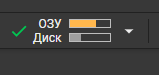


Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

# Описание решения (!)

1. Нанесение чёрных квадратов выполнено в разделе *Подготовка входных данных* с помощью функции apply_square().
2. В разделе *Создание и обучение автокодировщика* находятся два варианта решения задачи:
> - модель со скрытым пространством на Dense слое - на ней получена MSE 0.0036 на тестовой выборке;
> - модель с использованием только свёрточных слоёв - на ней получена MSE 0.0027 на тестовой выборке.
3. В разделе *Проверка результата* для каждой модели приведена рандомная выборка восстановленных изображений из тестовой выборки. Выглядит неплохо и даже магически :)
4. Несмотря на то, что с моделью на Dense-слое получен хороший результат, она явно уступает модели на свёрточных слоях, т.к. имеет в 20 раз больше тренируемых параметров и медленнее обучается, чем последняя.
5. При построении автокодировщика раздельно созданы модели кодировщика и декодировщика, которые затем объединены.
6. Для ускорения обучения - оно стартует с шагом 0.001 и далее используется callback с ручной настройкой, понижающий шаг обучения.


# Подготовка


## Импорт библиотек (исходный)

In [ ]:
 """
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt 

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Импортируем библиотеку numpy
import numpy as np 

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами 
import os 

# Для генерации случайных чисел 
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image 

# очистка ОЗУ
import gc
"""

'\n# Импортируем модели keras: Model\nfrom tensorflow.keras.models import Model\n\n# Импортируем стандартные слои keras\nfrom tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation\nfrom tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D\n\n# Импортируем оптимизатор Adam\nfrom tensorflow.keras.optimizers import Adam \n\n# Импортируем модуль pyplot библиотеки matplotlib для построения графиков\nimport matplotlib.pyplot as plt \n\n# Импортируем модуль image для работы с изображениями\nfrom tensorflow.keras.preprocessing import image \n\n# Импортируем библиотеку numpy\nimport numpy as np \n\n# Импортируем методделения выборки\nfrom sklearn.model_selection import train_test_split\n\n# загрузка файлов по HTML ссылке\nimport gdown\n\n# Для работы с файлами \nimport os \n\n# Для генерации случайных чисел \nimport random\n\nimport time\n\n# импортируем модель Image для работы с изображениями\nfrom PIL import Image \n\n# очистка ОЗУ\nim

## Импорт библиотек

In [ ]:
import numpy as np 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

import matplotlib.pyplot as plt
import seaborn as sns

import os, gdown, glob, time, copy, gc

# Дополнительные инструменты для работы с изображениями
# from PIL import Image

%matplotlib inline

## Загрузка датасета

In [ ]:
SOURCE_FILE = 'construction_256x192.zip'
# SOURCE_FILE = 'construction_512x384.zip'
DATA_DIR = './construction'

# загрузим данные, если нет папки с распакованным архивом
if not os.path.exists(DATA_DIR):

    # загрузим архив, если его нет на диске
    if not os.path.exists(SOURCE_FILE):
        gdown.download(f'https://storage.yandexcloud.net/aiueducation/Content/base/l14/{SOURCE_FILE}', None, quiet=True)

    # распаковка архива на локальный диск colab
    !mkdir {DATA_DIR[2:]}
    !unzip -qo {SOURCE_FILE} -d {DATA_DIR}

# Сервисные классы и функции

### ProgressBar - класс для вывода индикатора выполнения

In [ ]:
# выводит прогресс-бар
# event_index - текущее значение (начало отсчёта - 0)
# events_count - всего значений
# msg - сообщение, выводимое в строке
# bar_width = длина индикатора в символах
class ProgressBar():

    def __init__(self, events_count=None, bar_width=20):
        self.events_count = events_count
        self.bar_width = bar_width
        self.started = False

    # def reset(self, events_count, bar_width=20):
    #     self.events_count = events_count
    #     self.bar_width = bar_width
    #     self.started = False

    def start(self, msg, events_count=None):
        self.started = True
        self.start_time = time.time()
        self.message = msg
        if events_count is not None:
            self.events_count = events_count
        # вывод исходного состояния
        self.update(0)
    
    def update(self, event_index, msg=None):
        # первый запуск
        # if not self.started:
        #     self.started = True
        #     self.start_time = time.time()
        msg = self.message if msg is None else msg

        ready = self.bar_width * event_index // (self.events_count - 1)
        percent = event_index / (self.events_count - 1)
        digits = len(str(self.events_count))
        print(f'\r{percent:>4.0%}|{u"▓" * ready}{u"." * (self.bar_width - ready)}| {event_index + 1:{digits}d}/{self.events_count:{digits}d}: {msg}', end='', flush=True)    

        # последняя итерация
        if event_index >= self.events_count - 1:
            self.started = False
            self.execution_time = time.time() - self.start_time
            # завершим вывод
            print()
            print(f'Время выполнения: {self.execution_time:.1f} сек.')



### Вывод графика метрики модели и ошибки

In [ ]:
# Функция рисует графики обучения модели на одном полотне.
# Параметры:
#   history - объект *.history, возвращаемый методом модели fit()
def draw_history(history, metric=None, start_from_epoch=0):

    # количество выводимых графиков
    n = 1 if metric is None else 2

    sns.set(style='darkgrid', palette='dark') 
    plt.figure(figsize=(6 * n, 4))

    # отрисовка графика метрики
    if metric is not None:
        plt.subplot(1, n, 1)
        plt.plot(history[metric][start_from_epoch:], label='Обучающая выборка')
        plt.plot(history[f'val_{metric}'][start_from_epoch:], label='Проверочная выборка')
        plt.xlabel('Эпоха обучения')
        plt.ylabel(f'{metric}')
        plt.legend()

    # отрисовка графика ошибки
    plt.subplot(1, n, n)
    plt.plot(history['loss'][start_from_epoch:], label='Обучающая выборка')
    plt.plot(history['val_loss'][start_from_epoch:], label='Проверочная выборка')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Ошибка')
    plt.legend()

    print()
    plt.show()

### DataSampling - класс для управления выборками

In [ ]:
class DataSampling:

    # единичная выборка
    class Sample:

        # инициализация выборки
        def __init__(self, parent, name):
            self.name = name
            # инициализация наборов значений выборки
            for attr in parent.set_names:
                value = copy.deepcopy(parent.init_value)
                setattr(self, attr, value)

    # инициализация экземпляра класса
    # sample_names - названия выборок, используемых в приложении
    # set_names - имена инициализируемых наборов значений
    def __init__(self, sample_names, set_names, data_type, init_value=None):

        self.sample_names = sample_names
        self.set_names = set_names
        self.data_type = data_type
        self.init_value = init_value
        self.sample_count = len(sample_names)

        # инициализация выборок
        for i in range(self.sample_count):
            setattr(self, self.sample_names[i], self.Sample(self, self.sample_names[i]))

    # возвращает заданный набор значений из указанной выборки
    # sample_name - имя выборки
    # set_name - название набора значений
    def get(self, sample_name, set_name):
        return getattr(getattr(self, sample_name), set_name)

    # выводит формы всех наборов данных
    def print_shapes(self):
        if self.data_type == 'numpy':
            for sample_name in self.sample_names:
                print(f'Выборка {sample_name}:')
                for set_name in self.set_names:
                    sample = self.get(sample_name, set_name)
                    if isinstance(sample, np.ndarray):
                        print(f'  Форма набора данных {set_name}: {sample.shape}')
                    else:
                        print(f'  Содержимое набора данных {set_name}: {sample}')
        else:
            raise Exception(f'Вывод формы данных для значений {self.data_type} не предусмотрен.')


In [ ]:
print(copy.deepcopy(None))

None


### Функции вывода случайных изображений

In [ ]:
# выводит заданное количество случайных изображений 
# loc - количество и расположение картинок по вертикали и горизонтали,
#       которое нужно отобразить (y, x)
def show_random(data, loc=(3, 7), gray=False):

    fig = plt.figure(figsize=(2 * loc[1], 2 * loc[0]))
    ax = []

    # массивы numpy будем конвертировать в изображения
    do_convert = isinstance(data[0], np.ndarray)

    for i in range(loc[0] * loc[1]):

        # выберем случайную картинку
        img = data[np.random.randint(0, data.shape[0])]

        # конвертация
        if do_convert:
            img = utils.array_to_img(img)

        # выведем на полотно
        ax.append(fig.add_subplot(loc[0], loc[1], i + 1))
        if gray:
            ax[i].imshow(img[..., 0], cmap='gray')
        else:
            ax[i].imshow(img)
        ax[i].axis('off')

    # отобразим полотно
    plt.tight_layout()
    plt.show()

In [ ]:
# выводит попарно заданное количество случайных изображений 
# loc - количество и расположение картинок по вертикали и горизонтали,
#       которое нужно отобразить (y, x)
#       количество изображений в ширину будет равно x * 2
def show_random_pair(data, set_names, loc=(3, 4), gray=(False, False)):

    fig = plt.figure(figsize=(6 * loc[1], 2 * loc[0]))
    ax = []

    # получим две выборки из данных
    sample = []
    for i in range(2):
        sample.append(getattr(data, set_names[i]))

    # массивы numpy будем конвертировать в изображения
    do_convert = isinstance(sample[0][0], np.ndarray)
    # do_convert = False

    for i in range(loc[0] * loc[1]):

        # выберем случайно парные картинки
        index = np.random.randint(0, sample[0].shape[0])
        img = []
        img.append(sample[0][index])
        img.append(sample[1][index])

        # конвертация
        if do_convert:
            img[0] = utils.array_to_img(img[0])
            img[1] = utils.array_to_img(img[1])

        # выведем на полотно
        for axi in range(2):
            ax.append(fig.add_subplot(loc[0], loc[1] * 2, i * 2 + axi + 1))
            if gray[axi]:
                ax[i * 2 + axi].imshow(img[axi][..., 0], cmap='gray')
            else:
                ax[i * 2 + axi].imshow(img[axi])
            ax[i * 2 + axi].axis('off')

    # отобразим полотно
    plt.tight_layout()
    plt.show()

### LearningRateScheduler - класс для управления шагом обучения

In [ ]:
def lr_schedule(epoch, lr):
    # Helper function to retrieve the scheduled learning rate based on epoch
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr
    
class LearningRateScheduler(tf.keras.callbacks.Callback):

    def __init__(self, schedule):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('У оптимизатора должен быть атрибут "lr".')

        # получим текущий шаг обучения из оптимизатора
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

        # получим текущий шаг обучения из графика
        scheduled_lr = self.schedule(epoch, lr)

        # установим оптимизатору текущий шаг обучения
        if epoch == 0 or not np.isclose(lr, scheduled_lr):
            tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
            print(f'\nLearning rate set to {scheduled_lr}:')   

### HyperParameters - класс для удобной работы с гиперпараметрами

In [ ]:
class HyperParameters():

    def __init__(self):
        self.groups = dict()
        # параметры, по которым выводится описание
        self.known_keys = {
            'frame_length': 'длина текстовой последовательности',
            'frame_step': 'сдвиг окна при формировании текстовых последовательностей',
            'source_voc_size': 'размер общего словаря, извлекаемого из текста изначально',
            'voc_size': 'размер словаря для текущей модели',
            'ngrams': 'размер Ngram, на которые разбивается текст, либо None',
            'vectorize_mode': 'выходной формат слоя векторизации (int, multi_hot)',
            'train_size_ratio': 'доля обучающей выборки',
            'valid_size_ratio': 'доля проверочной выборки',
            'batch_size': 'размер батча',
            'learning_rate': 'шаг обучения',
            'epochs': 'количество эпох обучения',
            'embeddings_dim': 'размерность эмбеддингов',
            'optimizer': 'оптимизатор',
            'loss_fn': 'функция потерь'
        }

    # возвращает длину значения
    # если у значения есть атрибут name, то возвращается его длина
    def _get_value_length(self, attr):

        value = getattr(self, attr)

        # print(f':: value: {value}')

        if getattr(value, 'name', None) is not None:
            # print(f'>> {getattr(value, "name")}')
            return len(getattr(value, 'name'))
        else:
            return len(str(value))

    # формирует название гиперпараметра для печати
    def _format(self, attr, max_len):

        value = getattr(self, attr)
        
        # пока не будем печатать списки в параметрах
        if isinstance(value, list):
            value = 'list'

        # если у значения есть атрибут name, то возьмём его
        if getattr(value, 'name', None) is not None:
            p_value = getattr(value, 'name')
        else:
            p_value = str(value)

        output = f'{attr:<{max_len["param"]}}  {p_value:>{max_len["value"]}}'
        if attr in self.known_keys:
            output += f'  # {self.known_keys[attr]}'

        return output

    # запоминает в объекте переданные гиперпараметры
    def set(self, group='default', **kwargs):
        for key, value in kwargs.items():

            setattr(self, key, value)
            # добавим группу параметров, если она ещё не определена
            if group not in self.groups.keys():
                self.groups[group] = []

            # проверим уникальность параметра общем наборе
            # (если он есть, то переданная группа должна совпадать)
            for group_name, group_keys in self.groups.items():
                if key in group_keys and group != group_name:
                    raise ValueError(f'Key "{key}" must be unique in instance '
                    + f'of {self.__class__.__name__}. But found already exists in group "{group_name}".')

            # добавим параметр в группу, если его не существует
            if key not in self.groups[group]:
                self.groups[group] += [key]

    # выводит все гиперпараметры
    def print(self, *args, by_groups=True):

        exclude_list = ['known_keys', 'groups']

        # посчитаем максимальную длину строки: параметр + значение,
        # чтобы сделать красивый вывод
        max_len = {'param': 0, 'value': 0}
        for attr in self.__dict__:
            if attr not in exclude_list:
                len_param = len(attr)
                # len_value = len(str(getattr(self, attr)))
                len_value = self._get_value_length(attr)
                # print(f'{attr}, len_value: {len_value}')
                # print(f'attr: {attr}, {type(attr)}, {len_param}')
                # print(f'len_value: {len_value}')
                if len_param > max_len['param']:
                    max_len['param'] = len_param
                if len_value > max_len['value']:
                    max_len['value'] = len_value

        print('\nГИПЕРПАРАМЕТРЫ')

        # если передан список групп
        if len(args) > 0:
            for group in args:
                if group not in self.groups.keys():
                    raise ValueError(f'Group "{group}"" is not found within groups in instance of {self.__class__.__name__}.')
                print(' ', f'{group}:')
                for key in self.groups[group]:
                    print(' '*3, f'{self._format(key, max_len)}')
        else:
            for group in self.groups.keys():
                if by_groups:
                    print(' ', f'{group}:')
                indent = ' '*4 if by_groups else ' '*2
                for key in self.groups[group]:
                    print(f'{indent}{self._format(key, max_len)}')

### train_model - функция компиляции и обучения модели

In [ ]:
# функция компиляции и обучения модели
# def train_model(model, hp, x, y=None, validation_data=None):
def train_model(model, hp, data, sample_names, set_names):

    # оптимизатор
    if hp.optimizer == 'adam':
        optimizer = tf.keras.optimizers.Adam()
    elif hp.optimizer == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop()

    # компиляция
    model.compile(optimizer=optimizer, loss=hp.loss_fn, metrics=hp.metrics)

    # укажем директорию и именование файлов для TensorBoard (из текущей даты)
    # logdir = os.path.join("logs", get_str_date())

    # сформируем callback для TensorBoard
    # tensorboard_callback = tf.keras.callbacks.TensorBoard(
    #     logdir,
    #     histogram_freq=1,
    #     update_freq="epoch"
    #     )

    if data.data_type == 'numpy':
        batch_size = hp.batch_size
        # первая переданная выборка - тренировочная
        x_train = data.get(sample_names[0], set_names[0]),
        y_train = data.get(sample_names[0], set_names[1]),
        # вторая переданная выборка - проверочная
        validation_data = (
            data.get(sample_names[1], set_names[0]),
            data.get(sample_names[1], set_names[1])
        )
    else:
        batch_size = None
        y_train = None
        y_valid = None
        raise Exception('Для значений data_type кроме "numpy" функция на настроена.')

    # обучение
    record = model.fit(
                    x_train, y_train,
                    epochs=hp.epochs,            
                    batch_size=batch_size,
                    validation_data=validation_data,
                    callbacks=[
                        # tensorboard_callback,
                        LearningRateScheduler(lr_schedule),
                        ]
                    )
    return record, model  

# Загрузка и подготовка данных

### Подготовительные действия, загрузка и нормирование

hp = Hyper

In [ ]:
hp = HyperParameters()
hp.set('DATA',
    # высота изображения
    img_height = 192,
    # ширина изображения
    img_width=256,
    # class_count=None
    )

In [ ]:
# инициализируем объект для хранения двух выборок (тренировочной и тестовой)
# и наборов значений в них
dt = DataSampling(
    # имена выборок
    sample_names=['train', 'val'],
    # имена наборов значений
    set_names=['original', 'segment', 'reclassed'],
    # тип данных в выборке на этапе обучения
    data_type='numpy',
    # исходное значение для выборки
    init_value = []
    )

# проверим что атрибуты для хранения выборок созданы
for sample_name in dt.sample_names:    
    sample = getattr(dt, sample_name)
    print(f'Выборка "{sample_name}" ({sample}):')
    for set_name in dt.set_names:
        print(f'  {set_name}: {getattr(sample, set_name)}')

Выборка "train" (<__main__.DataSampling.Sample object at 0x7f04db27d910>):
  original: []
  segment: []
  reclassed: []
Выборка "val" (<__main__.DataSampling.Sample object at 0x7f045c228a90>):
  original: []
  segment: []
  reclassed: []


In [ ]:
# инициализируем индикатор выполнения
progress_bar = ProgressBar()

# считаем изображения для каждой из выборок
for sample_name in dt.sample_names:

    # зададим директории для оригинальных и сегментированных файлов
    dir_original = f'{DATA_DIR}/{sample_name}/{dt.set_names[0]}'
    dir_segment = f'{DATA_DIR}/{sample_name}/{dt.set_names[1]}'
    # print(f'Каталоги для чтения файлов:\n{dir_original}\n{dir_segment}')

    # список файлов в директории
    file_list = glob.glob(f'{dir_original}/*.bmp')
    # print(file_list[:3])
    # print(f'Файлов в каталоге {dir_original}: {len(file_list)}')
    
    # текущая выборка
    sample = getattr(dt, sample_name)

    # зададим начальное состояние индикатора выполнения
    progress_bar.start(msg=f'чтение изображений выборки {sample_name}', \
        events_count=len(file_list))

    # попарно считаем все оригинальные и сегментированные изображения
    # и сконвертируем их в numpy-массивы
    for i in range(len(file_list)):

        # прочитаем оригинальное изображения
        original_name = file_list[i]
        sample.original.append(
            utils.img_to_array(
                utils.load_img(
                    original_name,
                    target_size=(hp.img_height, hp.img_width)
                )
            )
        )
        # прочитаем соответствующее сегментированное изображение
        segment_file = original_name.replace(dt.set_names[0], dt.set_names[1])
        sample.segment.append(
            utils.img_to_array(
                utils.load_img(
                    segment_file,
                    target_size=(hp.img_height, hp.img_width)
                )
            )
        )
        # отобразим ход выполнения
        progress_bar.update(i)
    # print(f'\nСчитано изображений для выборки {sample_name}: {len(sample.original)} / {len(sample.segment)}')

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓| 1900/1900: чтение изображений выборки train
Время выполнения: 17.3 сек.
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓| 100/100: чтение изображений выборки val
Время выполнения: 0.7 сек.


In [ ]:
# преобразуем выборки в массивы numpy
for sample_name in dt.sample_names:
    # текущая выборка
    sample = getattr(dt, sample_name)

    sample.original = np.array(sample.original)
    sample.segment = np.array(sample.segment)
    # значения для реклассификации инициализируем нулями
    sample.reclassed = np.zeros(
        (sample.original.shape[0], hp.img_height, hp.img_width, 3), 
        dtype='uint8'
        )

In [ ]:
# проверим формы выборок
dt.print_shapes()

Выборка train:
  Форма набора данных original: (1900, 192, 256, 3)
  Форма набора данных segment: (1900, 192, 256, 3)
  Форма набора данных reclassed: (1900, 192, 256, 3)
Выборка val:
  Форма набора данных original: (100, 192, 256, 3)
  Форма набора данных segment: (100, 192, 256, 3)
  Форма набора данных reclassed: (100, 192, 256, 3)


In [ ]:
# цвета палитры Qlik
def qlik_colors():
    '''
    (0,172,172)
    (27,125,156)
    (77,167,65)
    (80,160,240)
    (102,194,150)
    (105,84,150)
    (141,170,203)
    (166,216,227)
    (171,233,188)
    (178,36,36)
    (179,179,179)
    (187,216,84)
    (190,108,44)
    (196,178,214)
    (229,182,148)
    (231,138,210)
    (240,160,80)
    (252,115,98)
    (255,191,201)
    (255,217,47)
    '''
    pass

(False, False) 0
(False, False) 0
(False, False) 1
(False, False) 1
(False, False) 2
(False, False) 2
(False, False) 3
(False, False) 3
(False, False) 4
(False, False) 4
(False, False) 5
(False, False) 5
(False, False) 6
(False, False) 6
(False, False) 7
(False, False) 7
(False, False) 8
(False, False) 8
(False, False) 9
(False, False) 9
(False, False) 10
(False, False) 10
(False, False) 11
(False, False) 11


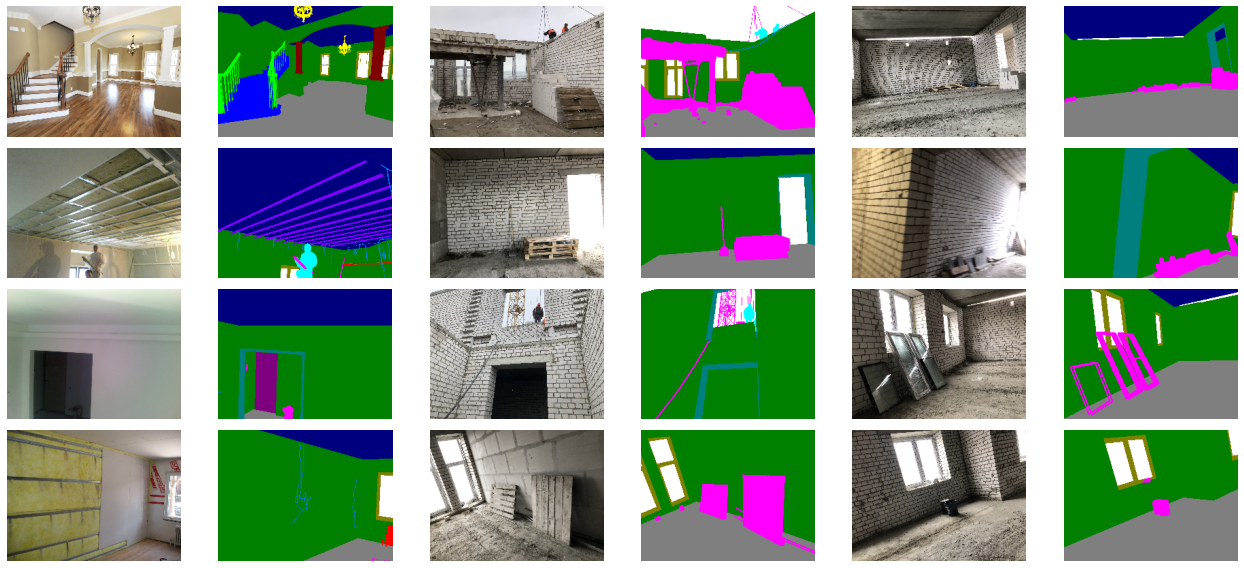

In [ ]:
# посмотрим несколько пар изображений тренировочной выборки
show_random_pair(dt.train, ['original', 'segment'], loc=(4, 3))

### Подготовка входных данных

In [ ]:
# создадим функцию для маппинга одних классов в другие
# def reclass(data, class_labels):
#     pass
#     return data

In [ ]:
# цвета пикселей сегментированных изображений
FLOOR = (100, 100, 100)         # Пол (серый)
CEILING = (0, 0, 100)           # Потолок (синий)
WALL = (0, 100, 0)              # Стена (зеленый)
COLUMN = (100, 0, 0)            # Колонна (красный)
APERTURE = (0, 100, 100)        # Проем (темно-бирюзовый)
DOOR = (100, 0, 100)            # Дверь (бордовый)
WINDOW = (100, 100, 0)          # Окно (золотой)
EXTERNAL = (200, 200, 200)      # Внешний мир (светло-серый)
RAILINGS = (0, 200, 0)          # Перила (светло-зеленый)
BATTERY = (200, 0, 0)           # Батареи (светло-красный)
PEOPLE = (0, 200, 200)          # Люди (бирюзовый)
LADDER = (0, 0, 200)            # Лестница (светло-синий)
INVENTORY = (200, 0, 200)       # Инвентарь (розовый)
LAMP = (200, 200, 0)            # Лампа (желтый)
WIRE = (0, 100, 200)            # Провод (голубой)
BEAM = (100, 0, 200)            # Балка (фиолетовый)
# общий кортеж меток
CLASS_LABELS = (FLOOR, CEILING, WALL, COLUMN, APERTURE, DOOR, WINDOW, \
    EXTERNAL, RAILINGS, BATTERY, PEOPLE, LADDER, INVENTORY, LAMP, WIRE, BEAM)

- создадим новый классификатор в соответствии с заданием: имя класса: метка класса
- сгенерим выходные данные, размеченные в соответствии с новым классификатором

In [ ]:
# новые метки классов в соответствии с заданием
NEW_CLASSES = {
    FLOOR: 0,
    CEILING: 1,
    WALL: 2,
    APERTURE: 3, DOOR: 3, WINDOW: 3,
    COLUMN: 4, RAILINGS: 4, LADDER: 4,
    INVENTORY: 5,
    LAMP: 6, WIRE: 6, BEAM: 6, EXTERNAL: 6, BATTERY: 6, PEOPLE: 6
}

In [ ]:
show_random(dt.train.segment, loc=(3, 7))

In [ ]:
print(f'Форма реклассифицированной выборки: {dt.train.reclassed.shape}')

In [ ]:
# проверим, что соответствие классов установлено корректно
for i, class_color in enumerate(CLASS_LABELS):
    print(f'{i} {class_color} {NEW_CLASSES.get(class_color)}')

In [ ]:
# зададим начальное состояние индикатора выполнения
progress_bar.start(msg=f'реклассификация сегментированных изображений', \
    events_count=len(CLASS_LABELS))

# классифицируем сегменты в соответствии с заданием
for i, class_color in enumerate(CLASS_LABELS):

    cl = NEW_CLASSES.get(class_color)
    clc = (cl, cl, cl)

    dt.train.reclassed = np.where(
        dt.train.segment == class_color, 
        clc, 
        dt.train.reclassed
        )
    
    progress_bar.update(i)
    # gc.collect()

In [ ]:
print(f'Форма реклассифицированной выборки: {dt.train.reclassed.shape}')

Форма реклассифицированной выборки: (1900, 192, 256, 3)


In [ ]:
print(dt.train.reclassed)

In [ ]:
# посмотрим несколько пар изображений сегментированных изображений
show_random_pair(dt.train, ['segment', 'reclassed'], loc=(4, 3), gray=(False, True))

In [ ]:
# нормировка данных
dt.train.y = dt.train.y.astype('float32')/255.
dt.test.y = dt.test.y.astype('float32')/255.

# изменение формы под удобную для Keras
# dt.train.y = dt.train.y.reshape((-1, 28, 28, 1))
# dt.test.y = dt.test.y.reshape((-1, 28, 28, 1))

# Создание и обучение модели

## Модель с использованием только свёрточных слоёв

### Создание и обучение модели

In [ ]:
# гиперпараметры модели
hp = HyperParameters()
hp.set('MODEL',
    epochs=8,
    # функция ошибки
    loss_fn=tf.keras.losses.MeanSquaredError(
        reduction="auto", name="MSE"
        ),
    # выбор оптимизатора
    optimizer=['adam', 'rmsprop', 'nadam'][0],
    # метрики
    metrics=None,
    # форма входа и выхода автокодировщика
    input_dim=dt.train.x[0].shape,    
    batch_size=32
    )
hp.print()

# график изменения шага обучения при наступлении заданной эпохи обучения
# (epoch, learning_rate)
LR_SCHEDULE = [
    # (0, 0.01),
    (0, 0.001),
    (3, 0.0001),
    (6, 0.00001),
    ]

# построение модели
def build_model(hp):

    # кодировщик
    encoder_input = keras.Input(shape=hp.input_dim, name="original_img")

    x = layers.Conv2D(16, 3, padding='same', activation="relu")(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # сжатие до (14, 14, 64)
    x = layers.Conv2D(64, 3, strides=2, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # сжатие до (7, 7, 256)
    x = layers.Conv2D(256, 3, strides=2, padding='same', activation="relu")(x)
    # x = layers.MaxPooling2D(2)(x)

    # encoder_output = layers.GlobalMaxPooling2D()(x)
    encoder_output = layers.BatchNormalization()(x)

    encoder = keras.Model(encoder_input, encoder_output, name="encoder")
    print()
    encoder.summary(line_length=120)

    # декодировщик

    decoder_input = keras.Input(shape=encoder_output.get_shape()[1:], name="encoded_img")

    # расширение до (14, 14, 128)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation="relu")(decoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    # расширение до (28, 28, 32)
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(16, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # decoder_output = layers.Conv2DTranspose(1, 3, padding='same', activation="relu")(x)
    decoder_output = layers.Conv2D(1, 3, padding='same', activation="sigmoid")(x)

    decoder = keras.Model(decoder_input, decoder_output, name="decoder")
    print()
    decoder.summary(line_length=120)

    # сборка автокодировщика из двух моделей

    autoencoder_input = keras.Input(shape=hp.input_dim, name="img")
    encoded_img = encoder(autoencoder_input)
    decoded_img = decoder(encoded_img)
    autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
    print()
    autoencoder.summary(line_length=120)

    return autoencoder

# создадим модель
model = build_model(hp)

# запустим функциию компиляции обучения модели, передав ей подготовленные даннные и
# указав какие выборки и наборы значений использовать
record, model = train_model(model, hp, dt,
    sample_names=['train', 'test'], 
    set_names=['x', 'y'])

# выведем графики ошибки
draw_history(record.history, metric=None, start_from_epoch=0)    

### Проверка результата

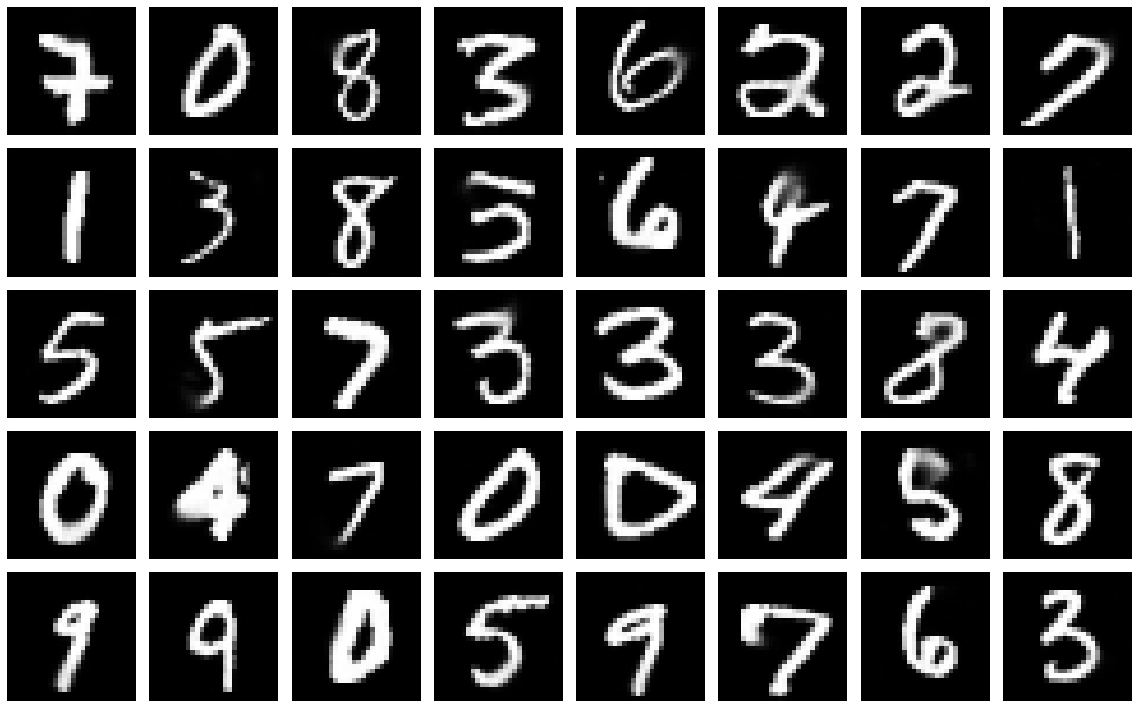

In [ ]:
pred = model.predict(dt.test.x)
show_random(pred, loc=(5, 8))

# Эксперименты

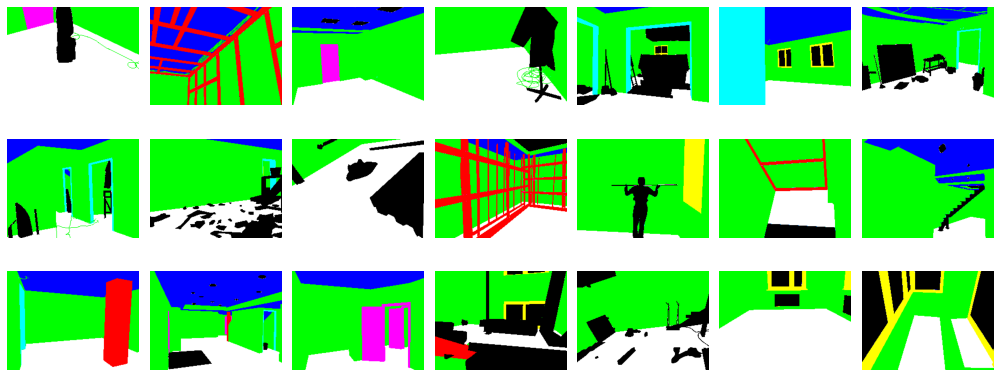

In [ ]:
# проверка конвертации цвета: заменим светло-серый на чёрный
imgs = dt.train.segment
imgs = np.where(imgs == (200, 200, 200), (0, 0, 0), imgs)
show_random(imgs, loc=(3, 7))

In [ ]:
# import scipy.misc
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,6)

# switch activation from softmax to linear
# visualize final layer output as an image and not class
model.layers[-1].activation = activations.linearmodel = utils.apply_modifications(model)

# Black Bear-295th index of the ImageNet dataset
img1 = visualize_activation(model,-1,\
           filter_indices=295,\
           max_iter=5000,\
           verbose=True)

# Polar Bear-296th index of the ImageNet dataset
img2 = visualize_activation(model,-1,\
           filter_indices=296,\
           max_iter=5000,\
           verbose=True)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(img1)
ax2.imshow(img2)